### Libraries

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import texthero as hero
from texthero import preprocessing
from texthero import stopwords
sb.set() # set the default Seaborn style for graphics
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.dates as mdates

### Chunking CSV to upload onto GitHub

import pandas as pd

chunk_size = 55000
batch_no = 1

for chunk in pd.read_csv('221100_DayZ.csv', chunksize=chunk_size):
    #chunk.to_csv('221100_DayZ' + str(batch_no) + '.csv', index=False)
    #batch_no +=1

### Dataset

In [2]:
steamData = pd.read_csv('steam_data/steam.csv')
#steamSupportInfo = pd.read_csv('steam_data/steam_support_info.csv')
#steamChart = pd.read_csv('steam_data/steamCharts.csv')
#steamSpyTagData = pd.read_csv('steam_data/steamspy_tag_data.csv')
steamGames = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_games/steam_games*.csv"))))
#steamMediaData = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_media_data/steam_media_data*.csv"))))
#steamRequirements = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_requirements/steam_requirements*.csv"))))
#steamDescription = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_description/steam_description*.csv"))))

#game reviews
#steam_HalfOfTheGameReviews = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))))
#files = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
#steamReviews_fromFolder = pd.concat([pd.read_csv(f) for f in files ])
#steamReviewsDF = [steam_HalfOfTheGameReviews, steamReviews_fromFolder]
#steamCombinedReviews = pd.concat(steamReviewsDF)


#game reviews
firstHalfReviewFiles =glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))
secondHalfReviewFiles = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
allReviewFiles = firstHalfReviewFiles + secondHalfReviewFiles
print(len(allReviewFiles))

191


### Cleaning the Dataset

##### renaming and getting the columns we need

In [3]:
#rename for easier identification
steamGames = steamGames.rename(columns={"name": "title"})
steamData = steamData.rename(columns={"name": "title", "genres":"genre"})

#drop columns
steamGames = steamGames[["title", "genre","release_date"]]
steamData = steamData[['title', 'genre', 'release_date','owners','positive_ratings', 'negative_ratings','price']]

#Check got any NA, if got drop
#steamGames.isna().sum()
#steamGames[steamGames['title'].isnull()]
steamGames = steamGames.dropna()

#steamData.isna().sum()

#####  text processing using texthero

In [4]:
#text processing for reviews
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(["game","mods","/"]))

custom_pipeline_review = [preprocessing.fillna
                          , preprocessing.lowercase
                          , preprocessing.remove_punctuation
                          , preprocessing.remove_diacritics
                          , preprocessing.remove_whitespace
                          ,preprocessing.remove_digits]
                          #, preprocessing.drop_no_content]

In [5]:
#text processing for title
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace]

steamGames['title'] = hero.clean(steamGames['title'], pipeline = custom_pipeline)
steamData['title'] = hero.clean(steamData['title'], pipeline = custom_pipeline)

In [6]:
# def chunks(lst, n):
#     #Yield successive n-sized chunks from lst
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]

# listofDF = list()
# for files in chunks(allReviewFiles,20):
#     reviewsDF = pd.concat([pd.read_csv(f, encoding = "ISO-8859-1", engine='python') for f in files])
#     reviewsDF = reviewsDF[["title", "review","voted_up"]]
#     reviewsDF = reviewsDF.reset_index(drop=True)
    
    
    
#     titleSerie = hero.clean(reviewsDF.title, pipeline = custom_pipeline)
#     reviewSerie = hero.clean(reviewsDF.review, pipeline=custom_pipeline_review)
#     reviewSerie = hero.remove_stopwords(reviewSerie, custom_stopwords)
#     voteSerie = reviewsDF[["voted_up"]]
    
    
#     reviewsTitle = pd.concat([titleSerie, reviewSerie, voteSerie], axis=1).reset_index(drop=True)

#     listofDF.append(reviewsTitle)

In [7]:
#reviewTitleDF = pd.concat(listofDF)

In [8]:
#reviewTitleDF.title.unique()

##### stored clean reviewTitle df in HDFStore as processing take about 11 minutes

In [9]:
store = pd.HDFStore('store.h5')
#store['reviewTitleDF'] = reviewTitleDF  # save it

In [10]:
#this take a while to load also but faster than processing
storedReviewsTitleDF = store['reviewTitleDF'] #load it

In [11]:
cleanReviewsTitle = storedReviewsTitleDF.rename(columns={"review": "clean_review"})
#cleanReviewsTitle

#convert any blank row to na and drop them
cleanReviewsTitle = cleanReviewsTitle.replace(r'^\s+$', np.nan, regex=True)

#cleanReviewsTitle.isna().sum()
#cleanReviewsTitle[cleanReviewsTitle['voted_up'].isnull()]
cleanReviewsTitle = cleanReviewsTitle.dropna()
cleanReviewsTitle = cleanReviewsTitle.reset_index()

# cleanReviewsTitle.isna().sum()
# cleanReviewsTitle.isnull().values.any()

##### putting the data into another dataframe 

In [12]:
steamGames_Title_Genre = steamGames
steamData_Title_Rating = steamData

##### matching title

In [13]:
#Genre
matchTitleGenre = steamGames_Title_Genre.title.isin(cleanReviewsTitle.title)
steamMatchTitleGenre = steamGames_Title_Genre[matchTitleGenre]
steamUniqueTitleGenre = steamMatchTitleGenre

#Rating
matchTitleRating = steamData_Title_Rating.title.isin(cleanReviewsTitle.title)
steamMatchTitleRating = steamData_Title_Rating[matchTitleRating]
steamUniqueTitleRating = steamMatchTitleRating

##### remove values that we don't use

In [14]:
#Genre
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Early Access?', '')
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace('Early Access,?', '')
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Free to Play?', '')
steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace('Free to Play,?', '')

steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('Early Access' , '')
steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('Coming Soon' , '')
steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('To Be Announced' , '')

#steamUniqueTitleGenre.to_excel("steamUniqueTitleGenre.xlsx")

#Rating
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace(';Early Access?', '')
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace('Early Access;?', '')
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace(';Free to Play?', '')
steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace('Free to Play;?', '')

#steamUniqueTitleRating.to_excel("steamUniqueTitleRating.xlsx")

<ipython-input-14-79a5f394d0a3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Early Access?', '')
<ipython-input-14-79a5f394d0a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace(',Early Access?', '')
<ipython-input-14-79a5f394d0a3>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitleGenre['genre'] = steamUniqueTitleGenre.genre.str.replace('Early Access,?', '')
<ipython-input-14-79a5f394d0a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

### Genre

##### split genre into 6 columns

In [15]:
steamUniqueTitleGenre[['genre1', 'genre2', 'genre3','genre4','genre5','genre6']] = steamUniqueTitleGenre['genre'].str.split(',', expand=True)

C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [16]:
steamUniqueTitleGenre.dtypes

title           object
genre           object
release_date    object
genre1          object
genre2          object
genre3          object
genre4          object
genre5          object
genre6          object
dtype: object

##### dropping genre, title, and release date columns to get the total count of genre

In [17]:
steamGenreCount = steamUniqueTitleGenre.drop(columns=['genre','title', 'release_date'])

##### reset index and rename the column

In [18]:
steamGenreGraph = steamGenreCount.stack().value_counts().reset_index()
steamGenreGraph.columns = ['genre','count']
steamGenreGraph

,genre,count
0,Action,59
1,Indie,50
2,Simulation,49
3,Strategy,35
4,Adventure,34
5,RPG,25
6,Massively Multiplayer,14
7,Casual,6
8,Sports,6
9,Racing,4


##### graph to see which genre is most popular 

<AxesSubplot:xlabel='genre', ylabel='count'>

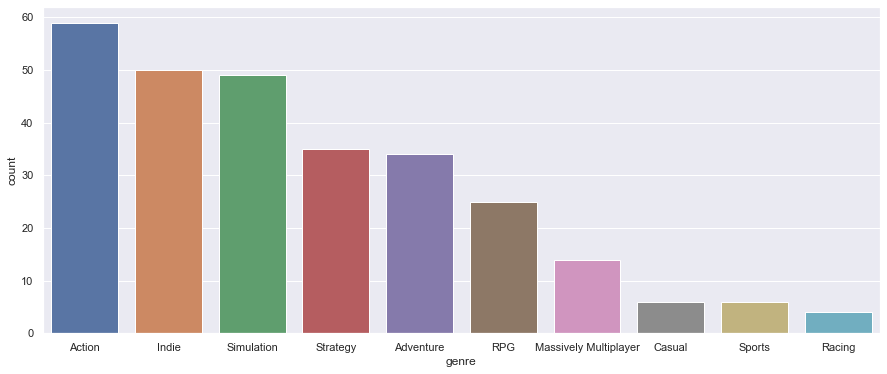

In [19]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb.barplot(x="genre", y="count", data=steamGenreGraph, ax=ax)

we can see that most of the games' genres are action, indie and simulation. Hence, We can conclude that players are most likely to play these genres compared to the rest.

In [20]:
# storing last 4 letters of release_date as year
steamGenre_Date = steamUniqueTitleGenre
steamGenre_Date['year'] = steamGenre_Date['release_date'].str.slice(-4)

#dropping unused columns
steamGenre_Date = steamUniqueTitleGenre.drop(columns=['title', 'genre1', 'genre2', 'genre3','genre4','genre5','genre6'])
steamGenre_Date

<ipython-input-20-e0a18ca26ae7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steamGenre_Date['year'] = steamGenre_Date['release_date'].str.slice(-4)


,genre,release_date,year
1,"Action,Adventure,Massively Multiplayer","Dec 21, 2017",2017
2,"Action,Adventure,Strategy","Apr 24, 2018",2018
3,"Action,Adventure,Massively Multiplayer","Dec 13, 2018",2018
7,"Adventure,Indie","Jul 22, 2016",2016
8,Strategy,"Dec 12, 2017",2017
...,...,...,...
1971,Action,"Feb 14, 2019",2019
3031,"Casual,Indie","Feb 13, 2019",2019
9343,"Simulation,Strategy",Q4 2019,2019
9790,Action,,


##### storing the top 3 genre individually

In [21]:
action =steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("action", case=False)]
indie =steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("indie", case=False)]
simulation = steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("simulation", case=False)]

##### converting year to int

In [22]:
action["year"] = pd.to_numeric(action["year"])
indie["year"] = pd.to_numeric(indie["year"])
simulation["year"] = pd.to_numeric(simulation["year"])

action["year"] = action["year"].fillna(0.0).astype(int)
indie["year"] = indie["year"].fillna(0.0).astype(int)
simulation["year"] = simulation["year"].fillna(0.0).astype(int)

<ipython-input-22-3eebed6f4e11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action["year"] = pd.to_numeric(action["year"])
<ipython-input-22-3eebed6f4e11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indie["year"] = pd.to_numeric(indie["year"])
<ipython-input-22-3eebed6f4e11>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

##### dropping rows that has 2020 in "year" column because it is outlier

In [23]:
# Get names of indexes for which column action has value 2020
indexAction = action[action['year'] == 2020].index
# Delete these row indexes from dataFrame
indexAction = action.drop(indexAction , inplace=True)

# Get names of indexes for which indie action has value 2020
indexIndie = indie[indie['year'] == 2020].index
# Delete these row indexes from dataFrame
indexIndie = indie.drop(indexIndie , inplace=True)

# Get names of indexes for which column simulation has value 2020
indexSimulation = simulation[simulation['year'] == 2020].index
# Delete these row indexes from dataFrame
indexIndie = simulation.drop(indexSimulation , inplace=True)


C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


##### grouping data based on year

In [24]:
groupedAction = action.groupby("year").count()
groupedIndie = indie.groupby("year").count()
groupedSimulation = simulation.groupby("year").count()

#reset index
groupedAction.reset_index(inplace=True)
groupedIndie.reset_index(inplace=True)
groupedSimulation.reset_index(inplace=True)

##### rename and convert the count to corresponding genre

In [25]:
groupedAction = groupedAction.rename(columns={'genre': 'action count'})
groupedAction['action count'] = groupedAction['action count'].astype(int)

groupedIndie = groupedIndie.rename(columns={'genre': 'indie count'}) 
groupedIndie['indie count'] = groupedIndie['indie count'].astype(int)

groupedSimulation = groupedSimulation.rename(columns={'genre': 'simulation count'})
groupedSimulation['simulation count'] = groupedSimulation['simulation count'].astype(int)

#drop "release_date" column
groupedAction = groupedAction.drop(columns=['release_date'])
groupedIndie = groupedIndie.drop(columns=['release_date'])
groupedSimulation = groupedSimulation.drop(columns=['release_date'])


##### merge the top 3 dataframes into one for lineplot

In [26]:
genreTimeLine = groupedAction.merge(groupedIndie,on='year').merge(groupedSimulation,on='year')
genreTimeLine

,year,action count,indie count,simulation count
0,2012,1,2,2
1,2013,2,1,3
2,2014,3,3,3
3,2015,6,5,7
4,2016,9,10,8
5,2017,7,5,4
6,2018,15,13,13
7,2019,9,9,7


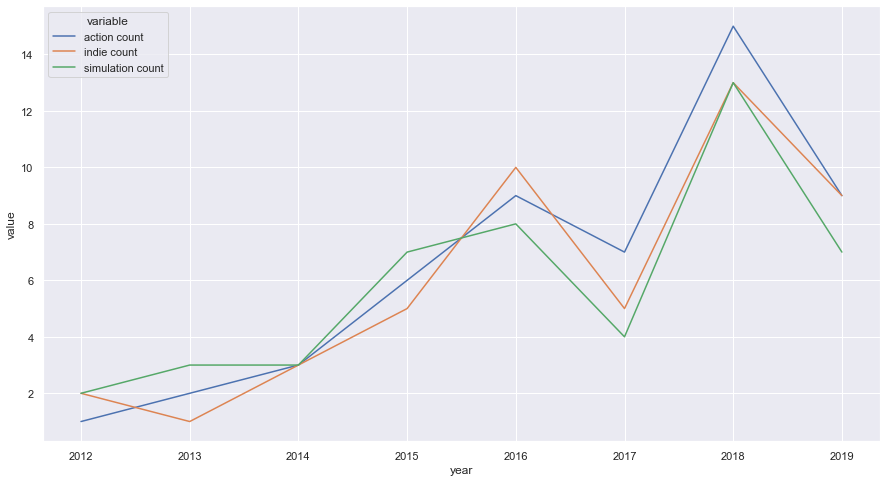

In [27]:
plt.figure(figsize=(15,8))
sb.lineplot(x='year', y='value', hue='variable', 
             data=pd.melt(genreTimeLine, ['year']))

ya = ax.get_yaxis()
ya.set_major_locator(MaxNLocator(integer=True))

xa = ax.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

plt.show()

 We can see that there is a sharp drop in 2019. 
 
 Based on this article, https://gamedaily.biz/article/1489/year-over-year-game-release-numbers-slowed-for-steam-in-2019 , they also said that there is a drop 2019 which is the same as the graph shown above. They mentioned that the drop may be due to the Steam’s notoriously-difficultmarketing and discoverability environment.

### Rating 

In [28]:
steamUniqueTitleRating

,title,genre,release_date,owners,positive_ratings,negative_ratings,price
0,counter strike,Action,2000-11-01,10000000-20000000,124534,3339,7.19
10,counter strike source,Action,2004-11-01,10000000-20000000,76640,3497,7.19
21,left 4 dead 2,Action,2009-11-19,10000000-20000000,251789,8418,7.19
23,portal 2,Action;Adventure,2011-04-18,10000000-20000000,138220,1891,7.19
121,garry s mod,Indie;Simulation,2006-11-29,10000000-20000000,363721,16433,6.99
...,...,...,...,...,...,...,...
21463,atlas,Action;Adventure;Massively Multiplayer;RPG,2018-12-22,1000000-2000000,8621,16359,23.79
22770,football manager 2019,Simulation;Sports,2018-11-02,200000-500000,2963,1004,37.99
24798,among us,Casual,2018-11-16,0-20000,60,11,3.99
25163,bloons td 6,Strategy,2018-12-17,200000-500000,516,251,6.99


In [29]:
steamUniqueTitleRating.dtypes

title                object
genre                object
release_date         object
owners               object
positive_ratings      int64
negative_ratings      int64
price               float64
dtype: object

In [30]:
ratingDF = steamUniqueTitleRating

In [31]:
ratingDF

,title,genre,release_date,owners,positive_ratings,negative_ratings,price
0,counter strike,Action,2000-11-01,10000000-20000000,124534,3339,7.19
10,counter strike source,Action,2004-11-01,10000000-20000000,76640,3497,7.19
21,left 4 dead 2,Action,2009-11-19,10000000-20000000,251789,8418,7.19
23,portal 2,Action;Adventure,2011-04-18,10000000-20000000,138220,1891,7.19
121,garry s mod,Indie;Simulation,2006-11-29,10000000-20000000,363721,16433,6.99
...,...,...,...,...,...,...,...
21463,atlas,Action;Adventure;Massively Multiplayer;RPG,2018-12-22,1000000-2000000,8621,16359,23.79
22770,football manager 2019,Simulation;Sports,2018-11-02,200000-500000,2963,1004,37.99
24798,among us,Casual,2018-11-16,0-20000,60,11,3.99
25163,bloons td 6,Strategy,2018-12-17,200000-500000,516,251,6.99


##### getting total ratings

In [32]:
def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = ratingDF['positive_ratings']
    neg = ratingDF['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-np.log10(total_reviews + 1))

    return score * 100

In [33]:
#steamUniqueTitleRating['owners'] = steamUniqueTitleRating['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

In [34]:
calcRating = calc_rating

In [35]:
print(calcRating)

<function calc_rating at 0x000002A33B0DA790>


In [36]:
ratingDF["rating"] = ""

<ipython-input-36-fce87ca2aad7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratingDF["rating"] = ""


In [37]:
#ratingDF['rating'] = ratingDF.apply(calc_rating, axis=1)

In [38]:
#keep lower bound of owners column, as integer
ratingDF['owners'] = steamUniqueTitleRating['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

# calculate rating, as well as simple ratio for comparison
ratingDF['total_ratings'] = ratingDF['positive_ratings'] + steamUniqueTitleRating['negative_ratings']
ratingDF['rating_ratio'] = ratingDF['positive_ratings'] / steamUniqueTitleRating['total_ratings']
ratingDF['rating'] = ratingDF.apply(calc_rating, axis=1)
#ratingDF['rating'] = ratingDF.apply(calc_rating)
    
# convert release_date to datetime type and create separate column for release_year
ratingDF['release_date'] = ratingDF['release_date'].astype('datetime64[ns]')
ratingDF['release_year'] = ratingDF['release_date'].apply(lambda x: x.year) 

<ipython-input-38-6235add563ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratingDF['owners'] = steamUniqueTitleRating['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
<ipython-input-38-6235add563ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratingDF['total_ratings'] = ratingDF['positive_ratings'] + steamUniqueTitleRating['negative_ratings']
<ipython-input-38-6235add563ec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [39]:
ratingDF

,title,genre,release_date,owners,positive_ratings,negative_ratings,price,rating,total_ratings,rating_ratio,release_year
0,counter strike,Action,2000-11-01,10000000,124534,3339,7.19,95.975678,127873,0.973888,2000
10,counter strike source,Action,2004-11-01,10000000,76640,3497,7.19,95.975678,80137,0.956362,2004
21,left 4 dead 2,Action,2009-11-19,10000000,251789,8418,7.19,95.975678,260207,0.967649,2009
23,portal 2,Action;Adventure,2011-04-18,10000000,138220,1891,7.19,95.975678,140111,0.986504,2011
121,garry s mod,Indie;Simulation,2006-11-29,10000000,363721,16433,6.99,95.975678,380154,0.956773,2006
...,...,...,...,...,...,...,...,...,...,...,...
21463,atlas,Action;Adventure;Massively Multiplayer;RPG,2018-12-22,1000000,8621,16359,23.79,95.975678,24980,0.345116,2018
22770,football manager 2019,Simulation;Sports,2018-11-02,200000,2963,1004,37.99,95.975678,3967,0.746912,2018
24798,among us,Casual,2018-11-16,0,60,11,3.99,95.975678,71,0.845070,2018
25163,bloons td 6,Strategy,2018-12-17,200000,516,251,6.99,95.975678,767,0.672751,2018


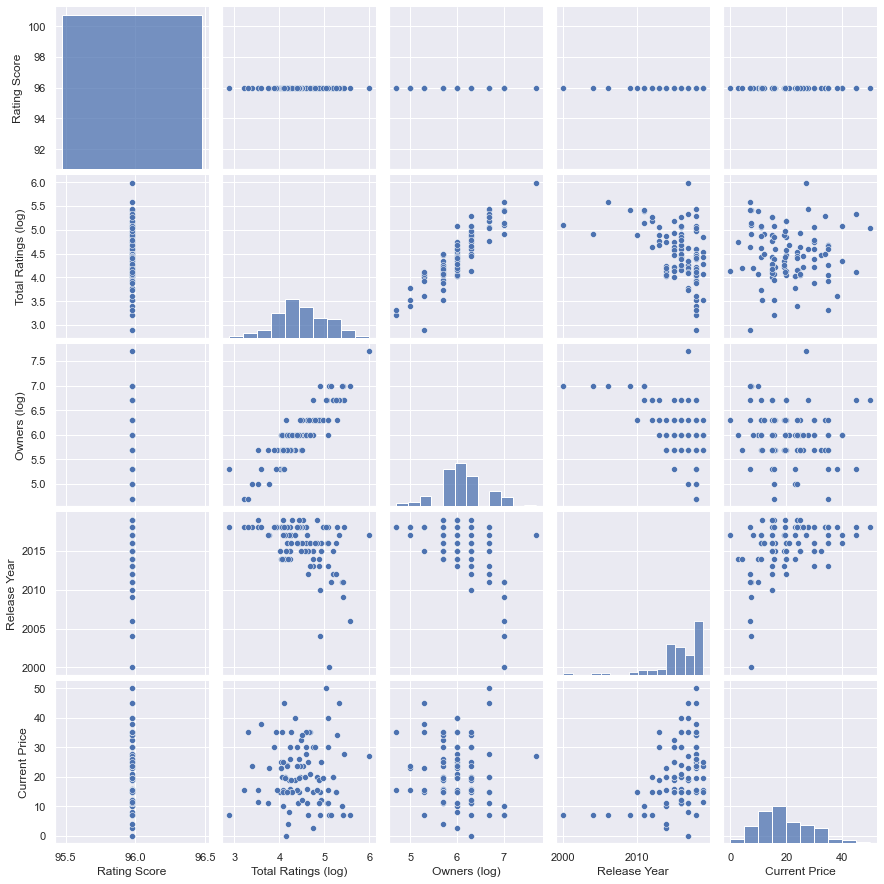

In [40]:
# ensure no 0s in columns we're applying log to
ratingDF = ratingDF[(ratingDF['owners'] > 0) & (ratingDF['total_ratings'] > 0)].copy()

eda_df = pd.DataFrame(zip(ratingDF['rating'],
                          np.log10(ratingDF['total_ratings']),
                          np.log10(ratingDF['owners']),
                          ratingDF['release_year'],
                          ratingDF.price
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price'])

sb.pairplot(eda_df)
plt.show()

We can see that: 

The more owners of a game, the more ratings it has. This suggests that the better rated a game, the more people buy it
More recent games are more expensive
There is an increase in number of the owner over the year.



We can conclude that:

The more owners of a game, the more ratings it has. This suggests that the better rated a game, the more people buy it

In [41]:
action = ratingDF.loc[ratingDF['genre'].str.contains("action", case=False)]
indie =ratingDF.loc[ratingDF['genre'].str.contains("indie", case=False)]
simulation = ratingDF.loc[ratingDF['genre'].str.contains("simulation", case=False)]
strategy = ratingDF.loc[ratingDF['genre'].str.contains("strategy", case=False)]
rpg = ratingDF.loc[ratingDF['genre'].str.contains("rpg", case=False)]
sports = ratingDF.loc[ratingDF['genre'].str.contains("sports", case=False)]
racing = ratingDF.loc[ratingDF['genre'].str.contains("racing", case=False)]

##### summing all the postive rating and negative rating separately

In [42]:
#action
action_posRating = action['positive_ratings'].sum()    
action_negRating = action['negative_ratings'].sum() 

#indie
indie_posRating = indie['positive_ratings'].sum()    
indie_negRating = indie['negative_ratings'].sum()  

#simulation
simulation_posRating = simulation['positive_ratings'].sum()    
simulation_negRating = simulation['negative_ratings'].sum() 

#strategy
strategy_posRating = strategy['positive_ratings'].sum()    
strategy_negRating = strategy['negative_ratings'].sum()

#rpg
rpg_posRating = rpg['positive_ratings'].sum()    
rpg_negRating = rpg['negative_ratings'].sum()

#sports
sports_posRating = sports['positive_ratings'].sum()    
sports_negRating = sports['negative_ratings'].sum()

#racing
racing_posRating = sports['positive_ratings'].sum()    
racing_negRating = sports['negative_ratings'].sum()

In [43]:
# initialize data of lists.
data = {'genre':['action', 'indie', 'simulation', 'strategy', 'rpg', 'sports', 'racing'],
        'positive_ratings':[action_posRating, indie_posRating, simulation_posRating, strategy_posRating, rpg_posRating, sports_posRating, racing_posRating],
        'negative_ratings':[action_negRating, indie_negRating, simulation_negRating, strategy_negRating, rpg_negRating, sports_negRating, racing_negRating]
       }
  
# Create DataFrame
genreRating = pd.DataFrame(data)

In [44]:
#sum_column = genreRating["positive_ratings"] + genreRating["negative_ratings"]
#genreRating["total_ratings"] = sum_column

In [45]:
genreRating = genreRating.set_index('genre')

In [46]:
genreRating = genreRating.div(genreRating.sum(axis=1), axis=0)*100

Text(0.5, 0, 'rating in percentage')

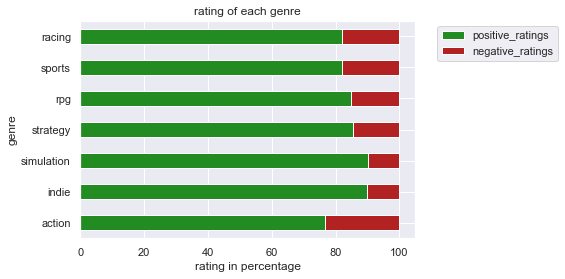

In [47]:
genreRating.plot(kind = 'barh', stacked = True, color=("forestgreen","firebrick"))
plt.legend(bbox_to_anchor=(1.05,1))
plt.title("rating of each genre")
plt.xlabel("rating in percentage")

we can see that simulation and indie have a lot more postive ratings compared to the rest. We thought that action would receive more postive rating as it is considered the most popular genre. The reason why simulation and indie has more postive rating may be due to factors such as lenghth of game play and content of the game which we will explore later.

### Reviews

In [48]:
cleanReviewsTitle

,index,title,clean_review,voted_up
0,0,7 days to die,turd,True
1,1,7 days to die,great hope people check see selves,True
2,2,7 days to die,good,True
3,3,7 days to die,haha bat hit zombie zombie head explode,True
4,4,7 days to die,zombie go grrr gun go brrrrrr,True
...,...,...,...,...
4517824,607321,the elder scrolls v skyrim,easily one best rpg year,True
4517825,607322,the elder scrolls v skyrim,epic,True
4517826,607324,the elder scrolls v skyrim,waifu simulator oh thank bethesda,True
4517827,607325,the elder scrolls v skyrim,get gnomers p fourms damned skyrim suck ...,True


In [ ]:
NUM_TOP_WORDS = 10

top_10 = hero.visualization.top_words(cleanReviewsTitle['clean_review']).head(NUM_TOP_WORDS)

# Draw the bar chart

top_10.plot.bar(rot=90, title="Top 10 words");

plt.show(block=True);


In [ ]:
hero.wordcloud(cleanReviewsTitle['clean_review'], max_words=200,)

Some popular words that can be observed here include “good,” “fun" and "great". Also, there are some negative words such
as "bad" and "bugs". However, there are more postivive word, indicating that most reviews in the dataset express a positive sentiment.

In [ ]:
cleanReviewsTitle

In [ ]:
cleanReviewsTitle.loc[cleanReviewsTitle['voted_up'] == True, 'sentimental'] = 1
cleanReviewsTitle.loc[cleanReviewsTitle['voted_up'] == False, 'sentimental'] = -1

In [ ]:
cleanReviewsTitle.dtypes

In [ ]:
cleanReviewsTitle['sentimental'] = cleanReviewsTitle['sentimental'].astype(int)

In [ ]:
cleanReviewsTitle

In [ ]:
positive = cleanReviewsTitle[cleanReviewsTitle['sentimental'] == 1]
negative = cleanReviewsTitle[cleanReviewsTitle['sentimental'] == -1]

In [ ]:
negative

In [ ]:
hero.wordcloud(negative['clean_review'], max_words=100,)

This shows the word cloud for all words appeared in reviews that are voted down. We can see that even if they are voted down, there are still some postivie words such as "good" and "fun". However, we also see some negative words such as "bad", "nothing" and "bugs". We also see words such as money and hours. 

From here we can assume that the games were voted down due to long hour play, havings bugs and not worth the money.

In [ ]:
new_cleanReviewsTitle = cleanReviewsTitle[['clean_review','sentimental']]

In [ ]:
new_cleanReviewsTitle

In [ ]:
#random split train and test data
# index = df.index
# df['random_number'] = np.random.randn(len(index))
# train = df[df['random_number'] <= 0.8]
# test = df[df['random_number'] > 0.8]